In [92]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm

from matplotlib import font_manager

font_family = font_manager.FontProperties(fname='C:/Windows/Fonts/malgunsl.ttf').get_name()
plt.rc('font', family=font_family)

In [66]:
def url_parser(sDate, eDate, row=10):
    key="개인 키 입력"
    
    url="http://openapi.data.go.kr/openapi/service/rest/Covid19/getCovid19SidoInfStateJson?serviceKey="+key
    url=url+"&pageNo=1&numOfRows="+str(row)
    url=url+"&startCreateDt="+str(sDate)
    url=url+"&endCreateDt="+str(eDate)
    
    xml_soup=requests.get(url)
    
    if xml_soup.status_code != 200:
        print('API 연결 오류')
        exit()
        
    soup=bs(xml_soup.text, 'html.parser')
    
    return soup
        
    

In [67]:
### 문자형 데이터를 날짜형으로 변경

import datetime

print(datetime.datetime.strptime("2021년 07월 14일 00시", "%Y년 %m월 %d일 00시").strftime("%Y%m%d"))
print("2021년 07월 14일 00시".replace("년 ","").replace("월 ","").replace("일 00시",""))

20210714
20210714


In [94]:
def covid_info(soup):
    items=soup.find_all('item')
    
    covid_list=[]
    for item in tqdm(items, desc='진행율='):
        stdDay=item.find('stdday').get_text()        # 기준일
        stdDay=stdDay.replace("년 ","").replace("월 ","")[0:8]  
        ### 년,월 글자 제거 후 8자리 가져오기(일 00시, 일 18시, 일 17시 등 제거)
        gubun=item.find('gubun').get_text()          # 지역명
        incDec=item.find('incdec').get_text()        # 당일 확진자
        defCnt=item.find('defcnt').get_text()        # 누적 확진자
        localCnt=item.find('localocccnt').get_text() # 지역
        overCnt=item.find('overflowcnt').get_text()  # 해외
        
        covid_list.append([stdDay, gubun, incDec, localCnt, overCnt, defCnt])
        
    df1=pd.DataFrame(covid_list, columns=['기준일', '지역명', '당일', '지역', '해외', '누적'])
    df1=df1.astype({'당일':"int64", "지역":"int64", "해외":"int64", "누적":"int64"})# 데이터 형식 변경
    df1.sort_values(by='기준일', inplace=True)   # 기준일을 기준으로 오름차순 정렬
    
    return df1

In [95]:
sDate='20200701'
eDate=datetime.datetime.today().strftime('%Y%m%d')

soup=url_parser(sDate, eDate)
row=soup.find('totalcount').text
soup=url_parser(sDate, eDate, row)
df1=covid_info(soup)

진행율=: 100%|███████████████████████████████████████████████████████████████████| 7200/7200 [00:00<00:00, 8474.46it/s]


In [96]:
df1['기준일']=pd.to_datetime(df1['기준일'])
df1[df1['기준일']=="2021-07-14"]

,기준일,지역명,당일,지역,해외,누적
7,2021-07-14,충북,10,9,1,3416
1,2021-07-14,제주,21,21,0,1433
2,2021-07-14,경남,89,87,2,5661
3,2021-07-14,경북,22,19,3,5085
4,2021-07-14,전남,6,6,0,1744
5,2021-07-14,전북,9,9,0,2463
6,2021-07-14,충남,36,36,0,4218
8,2021-07-14,강원,16,15,1,3770
13,2021-07-14,광주,15,15,0,3062
10,2021-07-14,세종,6,6,0,617


In [105]:
df2=df1[df1['지역명']=='대구']
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 379 entries, 7196 to 15
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   기준일     379 non-null    datetime64[ns]
 1   지역명     379 non-null    object        
 2   당일      379 non-null    int64         
 3   지역      379 non-null    int64         
 4   해외      379 non-null    int64         
 5   누적      379 non-null    int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 20.7+ KB


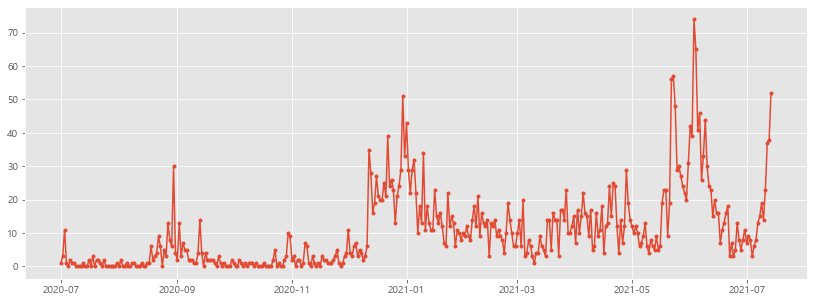

In [106]:
plt.style.use('ggplot') 
plt.figure(figsize=(14, 5))

plt.plot(df2.기준일, df2['당일'], marker="o", markersize=3)
plt.show()

조회 지역 입력:부산


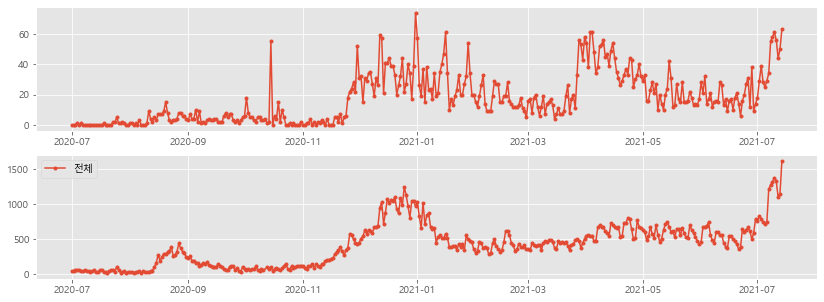

In [110]:
scLoc=input('조회 지역 입력:')

df2=df1[df1['지역명']==scLoc]
df3=df1[df1['지역명']=='합계']

plt.style.use('ggplot') 
plt.figure(figsize=(14, 5))

plt.subplot(2,1,1)
plt.plot(df2.기준일, df2['당일'], marker="o", markersize=3, label=scLoc)
plt.subplot(2,1,2)
plt.plot(df3.기준일, df3['당일'], marker="o", markersize=3, label='전체')
plt.legend()

plt.show()

### [미션] 합계부터 각 지역별 차트 출력
- 차트 제목 출력: 지역명으로 출력하되 합계는 '전체'로 출력